<a href="https://colab.research.google.com/github/renatoreggiani/acwiClassifier/blob/main/ClassificadorACWI.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Importando bibliotecas

In [ ]:
#@title
!pip install plotly==4.14.3
!pip install quandl

In [ ]:
import pandas as pd
import numpy as np
import pandas_datareader as pdr
import quandl
from ast import literal_eval

from sklearn.model_selection import cross_val_score, cross_validate 
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.preprocessing import MinMaxScaler
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.tree import plot_tree

import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import matplotlib.pyplot as plt

In [ ]:
# Necessario criar a key no quandl
key_quandl="Mw-vW_dxkPHHfjxjAQsF"

# Captura e tratamento dos dados

---



## Dados ACWI

In [ ]:
url_acwi = 'https://app2.msci.com/products/service/index/indexmaster/downloadLevelData?output=INDEX_LEVELS&currency_symbol=USD&index_variant=STRD&start_date=19800101&end_date=20210930&data_frequency=DAILY&baseValue=false&index_codes=892400'

# # para captura direto da web:
# df_acwi = pd.read_excel(url_acwi, skiprows=6).dropna()
# df_acwi['Date'] = pd.to_datetime(df_acwi['Date'], errors='coerce', format='%b %d, %Y')
# df_acwi.to_csv('/content/drive/MyDrive/TCC Puc Minas/ACWI.csv', index=False)

# # para executar na maq local
# df_acwi = pd.read_csv('ACWI.csv',parse_dates=['Date'])
  
# para executar no colab
df_acwi = pd.read_csv('/content/drive/MyDrive/TCC Puc Minas/ACWI.csv',parse_dates=['Date'])

df_acwi.rename(columns={df_acwi.columns[1]: df_acwi.columns[1].split()[0].upper()}, inplace=True)
df_acwi['year_week'] = df_acwi['Date'].dt.strftime('%Y-%U')
df_acwi.dropna(inplace=True)
df_acwi = df_acwi[df_acwi['Date']>'1997-01-01'].sort_values('Date')
df_acwi = df_acwi.groupby('year_week').agg('last')
df_acwi.sort_index(inplace=True)
df_acwi['log_diff'] = np.log(df_acwi['ACWI']/df_acwi['ACWI'].shift(1))
df_acwi.dropna(subset=['log_diff'], inplace=True)
df_acwi['std'] = df_acwi['log_diff'].rolling(52).std()
df_acwi.drop(columns='ACWI', inplace=True)
df_acwi

,Date,log_diff,std
year_week,,,
1997-01,1997-01-10,-0.004398,NaN
1997-02,1997-01-17,0.022479,NaN
1997-03,1997-01-24,-0.013039,NaN
1997-04,1997-01-31,0.010743,NaN
1997-05,1997-02-07,0.000220,NaN
...,...,...,...
2021-35,2021-09-03,0.012433,0.020001
2021-36,2021-09-10,-0.012376,0.020146
2021-37,2021-09-17,-0.009942,0.019922


## PMI

In [ ]:
def pmi_us_classified(key=key_quandl):

  df = quandl.get('ISM/MAN_PMI', authtoken=key, start_date="1996-11-01").sort_index()
  df['year_week'] = df.index.strftime('%Y-%U')
  mean_3m = df['PMI'].rolling(3).mean()

  #PMI classification
  df['pmi_us_gt_50_up'] = np.where((df['PMI'] > mean_3m) & (df['PMI'] >=50), 1, 0)
  df['pmi_us_gt_50_down'] = np.where((df['PMI'] < mean_3m) & (df['PMI'] >=50), 1, 0)
  df['pmi_us_lt_50_up'] = np.where((df['PMI'] > mean_3m) & (df['PMI'] < 50), 1, 0)
  df['pmi_us_lt_50_down'] = np.where((df['PMI'] < mean_3m) & (df['PMI'] < 50), 1, 0)

  df.drop(columns=[ 'PMI'], inplace=True)
  return df[df['year_week']>='1997-00'].set_index('year_week')

In [ ]:
df_pmi = pmi_us_classified()
df_pmi.head()

,pmi_us_gt_50_up,pmi_us_gt_50_down,pmi_us_lt_50_up,pmi_us_lt_50_down
year_week,,,,
1997-00,0,1,0,0
1997-04,0,1,0,0
1997-08,1,0,0,0
1997-13,1,0,0,0
1997-17,1,0,0,0


## Quandl data

In [ ]:
def get_quandl(id_quandl, curve_diff=None, key=key_quandl):
    df = quandl.get(id_quandl, authtoken=key, start_date="1996-12-01").sort_index()
    if curve_diff:
        if len(curve_diff) == 2:
            col_name = f'{id_quandl.split("/")[1]}: {"-".join(curve_diff)}'
            df[col_name] = df[curve_diff[0]] - df[curve_diff[1]]
            df = df[[col_name]]
        else:
            raise 'Diferença deve ser calculada com 2 pontos'
            
    df['year_week'] = df.index.strftime('%Y-%U')
    df = df.groupby('year_week').agg('last')
    return df

df_quandl = pd.concat([
  get_quandl('USTREASURY/HQMYC', curve_diff=('10.0', '20.0')),
  get_quandl('USTREASURY/YIELD', curve_diff=('3 MO', '7 YR')),
  get_quandl('USTREASURY/YIELD', curve_diff=('10 YR', '20 YR')),
  get_quandl('USTREASURY/YIELD', curve_diff=('10 YR', '30 YR'))
  ], join='outer', axis=1).sort_index()

In [ ]:
df_quandl.head()

,HQMYC: 10.0-20.0,YIELD: 3 MO-7 YR,YIELD: 10 YR-20 YR,YIELD: 10 YR-30 YR
1996-48,NaN,-1.13,-0.36,-0.27
1996-49,NaN,-1.30,-0.35,-0.25
1996-50,NaN,-1.23,-0.34,-0.24
1996-51,NaN,-1.10,-0.33,-0.24
1996-52,-0.52,-1.13,-0.30,-0.22


## FRED data

In [ ]:
series_fred = ['AAA10Y', 'BAMLH0A0HYM2EY', 'CPALTT01USM657N', 'DGS10',
 'DGS3MO', 'DTB1YR', 'DTB3', 'EMVMACROBUS', 'EMVMACROCONSUME', 'EMVMACROFININD',
 'EMVTAXESEMV', 'EPUSOVDEBT', 'FEDFUNDS', 'GEPUCURRENT', 'NCBCMDPMVCE', 'POILBREUSDM',
 'STLFSI2', 'TEDRATE', 'USD3MTD156N', 'VIXCLS', ]

df_fred = pd.concat(
    [pdr.get_data_fred(serie,  start='1996-01-01', end='2021-08-10') for serie in series_fred]
    , join='outer', axis=1).sort_index()

In [ ]:
df_fred['year_week'] = df_fred.index.strftime('%Y-%U')
df_fred = df_fred.groupby('year_week').agg('last')

In [ ]:
df_fred.head()

,AAA10Y,BAMLH0A0HYM2EY,CPALTT01USM657N,DGS10,DGS3MO,DTB1YR,DTB3,EMVMACROBUS,EMVMACROCONSUME,EMVMACROFININD,EMVTAXESEMV,EPUSOVDEBT,FEDFUNDS,GEPUCURRENT,NCBCMDPMVCE,POILBREUSDM,STLFSI2,TEDRATE,USD3MTD156N,VIXCLS
year_week,,,,,,,,,,,,,,,,,,,,
1996-00,1.11,NaN,0.586319,5.69,5.19,4.91,5.03,0.39749,1.39123,0.52999,7.68488,17.154278,5.56,NaN,41.823779,17.94,-0.4611,0.58,5.60547,13.58
1996-01,1.14,NaN,NaN,5.75,5.18,4.87,5.05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.1980,0.55,5.59766,14.23
1996-02,1.19,NaN,NaN,5.54,5.10,4.76,4.96,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.1929,0.54,5.50000,12.70
1996-03,1.17,NaN,NaN,5.65,5.11,4.77,4.97,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.4128,0.53,5.50000,12.00
1996-04,1.21,NaN,0.323834,5.66,4.99,4.60,4.85,0.12554,1.06705,0.37661,5.14695,0.000000,5.22,NaN,NaN,17.97,-0.4060,0.46,5.31250,13.23


## Join das capturas

In [ ]:
df_join = pd.concat([
  df_acwi,
  df_fred,
  df_quandl,
  df_pmi
  ], join='outer', axis=1).sort_index()
df_join.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1367 entries, 1996-00 to 2021-40
Data columns (total 31 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   Date                1306 non-null   datetime64[ns]
 1   log_diff            1306 non-null   float64       
 2   std                 1255 non-null   float64       
 3   AAA10Y              1349 non-null   float64       
 4   BAMLH0A0HYM2EY      1300 non-null   float64       
 5   CPALTT01USM657N     306 non-null    float64       
 6   DGS10               1349 non-null   float64       
 7   DGS3MO              1349 non-null   float64       
 8   DTB1YR              994 non-null    float64       
 9   DTB3                1349 non-null   float64       
 10  EMVMACROBUS         308 non-null    float64       
 11  EMVMACROCONSUME     308 non-null    float64       
 12  EMVMACROFININD      308 non-null    float64       
 13  EMVTAXESEMV         308 non-null    float64 

# Analise dos dados

---

In [ ]:
df = df_join.copy()

## ACWI


In [ ]:
#@title
def plot_pctchange_std(df, add_plot=[]):
  fig = go.Figure()
  df = df.copy().dropna(subset=['log_diff'])
  fig.add_trace(go.Scatter(    
      x=df['Date'],
      y=df['std'],
      mode='lines',
      showlegend=False,
      legendgroup="std",
      line=dict(width=0.5, color='grey')
      ))
  fig.add_trace(go.Scatter(
      x=df['Date'],
      y=df['std']*-1,
      fill='tonexty',
      name='std',
      legendgroup="std",
      mode='lines', line=dict(width=0.5, color='grey')
      ))
  fig.add_trace(go.Scatter(    
      x=df['Date'],
      y=df['log_diff'],
      mode='lines',
      name='ACWI log diff',
      line=dict(color='royalblue')
      ))

  for col in add_plot:
      fig.add_trace(go.Scatter(
      x=df['Date'],
      y=df[col],
      name=col,
      ))
  fig.update_layout(legend=dict(
    orientation="h",
    yanchor="bottom",
    y=1.02,
    xanchor="right",
    x=1
  ))
  fig.update_layout(title="AWCI semanal")
  fig.update_xaxes(tickformat="%Y-%m-%d")
  fig.update_yaxes(tickformat = '.2%')  
  return fig

plot_pctchange_std(df_acwi).show(renderer='colab')

In [ ]:
fig = px.histogram(df, x='log_diff', nbins=150, marginal="box", title='Histrograma ACWI', )
fig.add_vline(x=0, line_dash="dash", opacity=0.7)
fig.show()

In [ ]:
neg_returns = df[df['log_diff'] < -0.0]['log_diff']
pd.DataFrame({'ACWI log diff':df['log_diff'].describe(),'| ACWI log diff < 0': neg_returns.describe()})

,ACWI log diff,| ACWI log diff < 0
count,1306.000000,566.000000
mean,0.000968,-0.018140
std,0.023860,0.020221
min,-0.223989,-0.223989
25%,-0.010360,-0.024186
50%,0.002793,-0.012564
75%,0.013618,-0.004948
max,0.116644,-0.000034


In [ ]:
print(
    'Valores Positivos: {:.2f} %'.format(100*((len(df) - len(neg_returns))/len(df)),2),
    'Valores Negativos: {:.2f} %'.format(100*len(neg_returns)/len(df), 2),
    sep='\n')

Valores Positivos: 58.60 %
Valores Negativos: 41.40 %


In [ ]:
df['category'] = np.where(df['log_diff'] < np.quantile(neg_returns,0.5), 1, 0)
df['category'].value_counts()

0    1084
1     283
Name: category, dtype: int64

In [ ]:
fig = plot_pctchange_std(df_acwi)
fig.add_trace(go.Scatter(
    x=df[df['category']==1]['Date'],
    y=df[df['category']==1]['category']*-0.018, marker_size=10,
    mode='markers',marker_symbol='triangle-down',
    name='Category = 1',
    marker=dict(color='darkred', opacity=0.6)
    ))

fig.show()

## Dataset com todas as variaveis

In [ ]:
df.drop(columns='std',inplace=True)
df.drop(columns=['category']).describe().T

,count,mean,std,min,25%,50%,75%,max
log_diff,1306.0,0.000968,0.023860,-0.223989,-0.010360,0.002793,0.013618,0.116644
AAA10Y,1349.0,1.497376,0.439660,0.630000,1.150000,1.530000,1.810000,3.200000
BAMLH0A0HYM2EY,1300.0,8.620362,2.932801,3.950000,6.370000,7.980000,10.200000,22.860000
CPALTT01USM657N,306.0,0.187390,0.352686,-1.915290,0.000000,0.186101,0.421002,1.221996
DGS10,1349.0,3.670971,1.589297,0.550000,2.310000,3.690000,4.850000,7.060000
DGS3MO,1349.0,2.088873,2.070391,0.000000,0.110000,1.480000,4.480000,6.380000
DTB1YR,994.0,1.981117,2.117409,0.040000,0.180000,0.765000,4.440000,6.070000
DTB3,1349.0,2.037561,2.014001,-0.010000,0.110000,1.450000,4.370000,6.200000
EMVMACROBUS,308.0,0.440593,0.413110,0.000000,0.186615,0.335135,0.546612,3.951730
EMVMACROCONSUME,308.0,2.084610,1.471022,0.258640,1.162697,1.699520,2.460225,11.207470


In [ ]:
px.line(df, x='Date', y='YIELD: 10 YR-30 YR')

In [ ]:
df.drop(columns='YIELD: 10 YR-30 YR', inplace=True)

### Valores Nulos

In [ ]:
log_diff_null = df['log_diff'].isnull()
df.ffill(inplace=True)
df = df.loc[~log_diff_null.values]
df

,Date,log_diff,AAA10Y,BAMLH0A0HYM2EY,CPALTT01USM657N,DGS10,DGS3MO,DTB1YR,DTB3,EMVMACROBUS,EMVMACROCONSUME,EMVMACROFININD,EMVTAXESEMV,EPUSOVDEBT,FEDFUNDS,GEPUCURRENT,NCBCMDPMVCE,POILBREUSDM,STLFSI2,TEDRATE,USD3MTD156N,VIXCLS,HQMYC: 10.0-20.0,YIELD: 3 MO-7 YR,YIELD: 10 YR-20 YR,pmi_us_gt_50_up,pmi_us_gt_50_down,pmi_us_lt_50_up,pmi_us_lt_50_down,category
1997-01,1997-01-10,-0.004398,0.83,9.64,0.315259,6.63,5.17,5.35,5.04,0.27409,1.58970,0.54817,8.44184,0.00000,5.25,76.436175,40.485251,23.470000,-0.1057,0.52,5.56250,19.63,-0.52,-1.35,-0.31,0.0,1.0,0.0,0.0,0
1997-02,1997-01-17,0.022479,0.83,9.56,0.315259,6.56,5.14,5.29,5.01,0.27409,1.58970,0.54817,8.44184,0.00000,5.25,76.436175,40.485251,23.470000,-0.3145,0.55,5.56250,18.63,-0.52,-1.32,-0.34,0.0,1.0,0.0,0.0,0
1997-03,1997-01-24,-0.013039,0.86,9.53,0.315259,6.64,5.16,5.31,5.03,0.27409,1.58970,0.54817,8.44184,0.00000,5.25,76.436175,40.485251,23.470000,-0.3687,0.53,5.56250,19.33,-0.52,-1.37,-0.33,0.0,1.0,0.0,0.0,1
1997-04,1997-01-31,0.010743,0.86,9.49,0.314268,6.53,5.15,5.29,5.02,0.27438,1.20728,0.32926,6.58514,0.00000,5.19,79.170087,40.485251,20.830000,-0.2672,0.54,5.56250,19.47,-0.49,-1.25,-0.33,0.0,1.0,0.0,0.0,0
1997-05,1997-02-07,0.000220,0.91,9.39,0.314268,6.43,5.14,5.20,5.01,0.27438,1.20728,0.32926,6.58514,0.00000,5.19,79.170087,40.485251,20.830000,-0.2187,0.53,5.54297,18.90,-0.49,-1.18,-0.35,0.0,1.0,0.0,0.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-35,2021-09-03,0.012433,1.26,4.21,0.929066,1.36,0.05,0.08,0.05,0.51687,0.86145,0.68916,4.82413,49.24922,0.09,188.815918,19.184760,70.020909,-0.8655,0.07,0.12275,16.79,-0.77,-1.04,-0.54,1.0,0.0,0.0,0.0,0
2021-36,2021-09-10,-0.012376,1.26,4.21,0.929066,1.36,0.05,0.08,0.05,0.51687,0.86145,0.68916,4.82413,49.24922,0.09,188.815918,19.184760,70.020909,-0.8655,0.07,0.12275,16.79,-0.77,-1.07,-0.51,1.0,0.0,0.0,0.0,0
2021-37,2021-09-17,-0.009942,1.26,4.21,0.929066,1.36,0.05,0.08,0.05,0.51687,0.86145,0.68916,4.82413,49.24922,0.09,188.815918,19.184760,70.020909,-0.8655,0.07,0.12275,16.79,-0.77,-1.13,-0.48,1.0,0.0,0.0,0.0,0
2021-38,2021-09-24,0.000645,1.26,4.21,0.929066,1.36,0.05,0.08,0.05,0.51687,0.86145,0.68916,4.82413,49.24922,0.09,188.815918,19.184760,70.020909,-0.8655,0.07,0.12275,16.79,-0.77,-1.24,-0.47,1.0,0.0,0.0,0.0,0


### Variaveis explicativas numericas

In [ ]:
numeric_cols= [c for c in df.columns if not c.startswith('pmi')  if c != 'category']
correl = df[numeric_cols].corr()

fig = px.imshow(correl, width=1000, height=1000, color_continuous_scale='RdBu', zmin=-1)
fig.show()

In [ ]:
correl[((correl>0.85)&(correl!=1))|(correl<-0.85)].dropna(how='all').dropna(axis=1, how='all').fillna('--')

,DGS3MO,DTB1YR,DTB3,FEDFUNDS,USD3MTD156N
DGS3MO,--,0.879526,0.999993,0.99424,0.98456
DTB1YR,0.879526,--,0.879441,0.875726,0.872582
DTB3,0.999993,0.879441,--,0.99421,0.984455
FEDFUNDS,0.99424,0.875726,0.99421,--,0.989352
USD3MTD156N,0.98456,0.872582,0.984455,0.989352,--


In [ ]:
# df.drop(columns=['USD3MTD156N','DGS3MO', 'FEDFUNDS', 'DTB1YR'], inplace=True)
# Mantido o DTB3 pois são os titulos de curto prazo negociados no mercado secundario

In [ ]:
df['DGS10'] = df['DGS10'].pct_change()
df['DTB3'] = df['DTB3'].pct_change()

## Variaveis explicativas categoricas

### PMI

In [ ]:
df['lag_log_diff'] = df['log_diff'].shift(-1)
df['lag_category'] = df['category'].shift(-1)

In [ ]:
desc_list = []
for c in [c for c in df.columns if c.startswith('pmi')]:
  desc = df[(df[c]==1)]['lag_log_diff'].describe()
  desc_list.append(pd.DataFrame(desc.values, columns=[c], index=desc.index))
pd.concat(desc_list, axis=1)

,pmi_us_gt_50_up,pmi_us_gt_50_down,pmi_us_lt_50_up,pmi_us_lt_50_down
count,556.000000,452.000000,107.000000,186.000000
mean,0.002004,0.000671,-0.001811,-0.000069
std,0.018192,0.021001,0.032232,0.036564
min,-0.110527,-0.089540,-0.097720,-0.223989
25%,-0.008423,-0.009880,-0.024628,-0.013818
50%,0.002793,0.002803,0.001765,0.002969
75%,0.012657,0.012999,0.017870,0.015421
max,0.073060,0.080252,0.080761,0.116644


In [ ]:
desc_list = []
for c in [c for c in df.columns if c.startswith('pmi')]:
  desc = df[(df[c]==1) & (df['lag_category']==1)]['lag_log_diff'].describe()
  desc_list.append(pd.DataFrame(desc.values, columns=[c], index=desc.index))
pd.concat(desc_list, axis=1)

,pmi_us_gt_50_up,pmi_us_gt_50_down,pmi_us_lt_50_up,pmi_us_lt_50_down
count,106.000000,92.000000,38.000000,47.000000
mean,-0.024562,-0.029834,-0.036034,-0.041417
std,0.013364,0.016362,0.019539,0.039398
min,-0.110527,-0.089540,-0.097720,-0.223989
25%,-0.029093,-0.038433,-0.037436,-0.038018
50%,-0.021198,-0.023921,-0.029457,-0.028217
75%,-0.015298,-0.018973,-0.023484,-0.020543
max,-0.012575,-0.012670,-0.014919,-0.014263


# Preparação dos dados para o Modelo

---

In [ ]:

df_model = df_join.copy()
df_model.drop(columns=['USD3MTD156N','DGS3MO', 'FEDFUNDS', 'DTB1YR', 'Date', 'std', 'YIELD: 10 YR-30 YR'], inplace=True)
log_diff_null = df_model['log_diff'].isnull()
df_model.ffill(inplace=True)
df_model = df_model.loc[~log_diff_null.values]

df_model['DGS10'] = df_model['DGS10'].pct_change().replace(np.inf, 0)
df_model['DTB3'] = df_model['DTB3'].pct_change().replace(np.inf, 0)

median_neg = np.quantile(df_model[df_model['log_diff'] < -0.0]['log_diff'],0.5)
df_model['category'] = np.where(df_model['log_diff'] < median_neg, 1, 0)
df_model['category'] = df_model['category'].shift(-1)

df_model.dropna(inplace=True)
df_model

,log_diff,AAA10Y,BAMLH0A0HYM2EY,CPALTT01USM657N,DGS10,DTB3,EMVMACROBUS,EMVMACROCONSUME,EMVMACROFININD,EMVTAXESEMV,EPUSOVDEBT,GEPUCURRENT,NCBCMDPMVCE,POILBREUSDM,STLFSI2,TEDRATE,VIXCLS,HQMYC: 10.0-20.0,YIELD: 3 MO-7 YR,YIELD: 10 YR-20 YR,pmi_us_gt_50_up,pmi_us_gt_50_down,pmi_us_lt_50_up,pmi_us_lt_50_down,category
1997-02,0.022479,0.83,9.56,0.315259,-0.010558,-0.005952,0.27409,1.58970,0.54817,8.44184,0.00000,76.436175,40.485251,23.470000,-0.3145,0.55,18.63,-0.52,-1.32,-0.34,0.0,1.0,0.0,0.0,1.0
1997-03,-0.013039,0.86,9.53,0.315259,0.012195,0.003992,0.27409,1.58970,0.54817,8.44184,0.00000,76.436175,40.485251,23.470000,-0.3687,0.53,19.33,-0.52,-1.37,-0.33,0.0,1.0,0.0,0.0,0.0
1997-04,0.010743,0.86,9.49,0.314268,-0.016566,-0.001988,0.27438,1.20728,0.32926,6.58514,0.00000,79.170087,40.485251,20.830000,-0.2672,0.54,19.47,-0.49,-1.25,-0.33,0.0,1.0,0.0,0.0,0.0
1997-05,0.000220,0.91,9.39,0.314268,-0.015314,-0.001992,0.27438,1.20728,0.32926,6.58514,0.00000,79.170087,40.485251,20.830000,-0.2187,0.53,18.90,-0.49,-1.18,-0.35,0.0,1.0,0.0,0.0,0.0
1997-06,0.019731,0.89,9.27,0.314268,-0.023328,-0.007984,0.27438,1.20728,0.32926,6.58514,0.00000,79.170087,40.485251,20.830000,-0.3363,0.53,19.18,-0.49,-1.08,-0.36,0.0,1.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-34,0.020081,1.26,4.21,0.929066,0.000000,0.000000,0.51687,0.86145,0.68916,4.82413,49.24922,188.815918,19.184760,70.020909,-0.8655,0.07,16.79,-0.77,-1.04,-0.53,0.0,1.0,0.0,0.0,0.0
2021-35,0.012433,1.26,4.21,0.929066,0.000000,0.000000,0.51687,0.86145,0.68916,4.82413,49.24922,188.815918,19.184760,70.020909,-0.8655,0.07,16.79,-0.77,-1.04,-0.54,1.0,0.0,0.0,0.0,0.0
2021-36,-0.012376,1.26,4.21,0.929066,0.000000,0.000000,0.51687,0.86145,0.68916,4.82413,49.24922,188.815918,19.184760,70.020909,-0.8655,0.07,16.79,-0.77,-1.07,-0.51,1.0,0.0,0.0,0.0,0.0
2021-37,-0.009942,1.26,4.21,0.929066,0.000000,0.000000,0.51687,0.86145,0.68916,4.82413,49.24922,188.815918,19.184760,70.020909,-0.8655,0.07,16.79,-0.77,-1.13,-0.48,1.0,0.0,0.0,0.0,0.0


In [ ]:
y = df_model['category'].values
X = df_model.drop(columns='category').values

In [ ]:
print('Quantidade\n0: {}\n1:  {}'.format(*np.unique(y, return_counts=True)[1]))

Quantidade
0: 1021
1:  283


### Variaveis explicativas com ajuste da escala

In [ ]:
scaler = MinMaxScaler()
scaler.fit(X)
X = scaler.transform(X)
pd.DataFrame(X).head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23
0,0.723558,0.077821,0.296668,0.710980,0.449014,0.150794,0.069359,0.121571,0.110372,0.362155,0.0,0.072260,0.541766,0.110154,0.079783,0.108407,0.135591,0.398010,0.509346,0.684211,0.0,1.0,0.0,0.0
1,0.619288,0.089494,0.295082,0.710980,0.479549,0.151999,0.069359,0.121571,0.110372,0.362155,0.0,0.072260,0.541766,0.110154,0.074533,0.103982,0.145592,0.398010,0.497664,0.692982,0.0,1.0,0.0,0.0
2,0.689106,0.089494,0.292967,0.710664,0.440950,0.151274,0.069433,0.086643,0.061306,0.265013,0.0,0.079433,0.541766,0.088881,0.084365,0.106195,0.147593,0.412935,0.525701,0.692982,0.0,1.0,0.0,0.0
3,0.658213,0.108949,0.287678,0.710664,0.442631,0.151274,0.069433,0.086643,0.061306,0.265013,0.0,0.079433,0.541766,0.088881,0.089063,0.103982,0.139448,0.412935,0.542056,0.675439,0.0,1.0,0.0,0.0
4,0.715491,0.101167,0.281333,0.710664,0.431876,0.150547,0.069433,0.086643,0.061306,0.265013,0.0,0.079433,0.541766,0.088881,0.077671,0.103982,0.143449,0.412935,0.565421,0.666667,0.0,1.0,0.0,0.0



# Modelos

---

## Funções e seed para os modelos

In [ ]:
class_weight = {1: y[y == 0].size / y.size,
                0: y[y == 1].size / y.size} 
class_weight

{0: 0.2170245398773006, 1: 0.7829754601226994}

In [ ]:
SEED = 51
N_ITER =  100   
N_SPLITS = 100
ss = StratifiedShuffleSplit(n_splits=N_SPLITS, test_size=0.2, random_state=SEED)

In [ ]:
def valid(model, X, y):
  ss_valid = StratifiedShuffleSplit(n_splits=N_SPLITS, test_size=0.2, random_state=666)
  scores = cross_val_score(model, X, y, scoring='balanced_accuracy', cv=ss_valid, n_jobs=-1)
  results = {
      'Modelo': str(model).split('(')[0],
      'Media': scores.mean(),
      'std': scores.std(),
      'Pior': scores.min(),
      'Melhor': scores.max(),
      'Parametros': model.get_params()
  }
  return pd.DataFrame([results])

  
def hp_tunning(model, params, random_state=SEED, n_iter=N_ITER, cv=ss):
  print(f'Testando hiperparametros para {str(model).split("(")[0]}' )
  clf = RandomizedSearchCV(model, params, random_state=random_state, scoring='balanced_accuracy',
                           n_iter=n_iter, cv=cv, n_jobs=-1, verbose=1)
  rsearch = clf.fit(X, y)
  df_rs = pd.DataFrame(rsearch.cv_results_)
  df_rs = df_rs[[col for col in df_rs.columns if not col.startswith('split')]].sort_values('rank_test_score')
  return rsearch.best_params_, df_rs

## **Random forest**

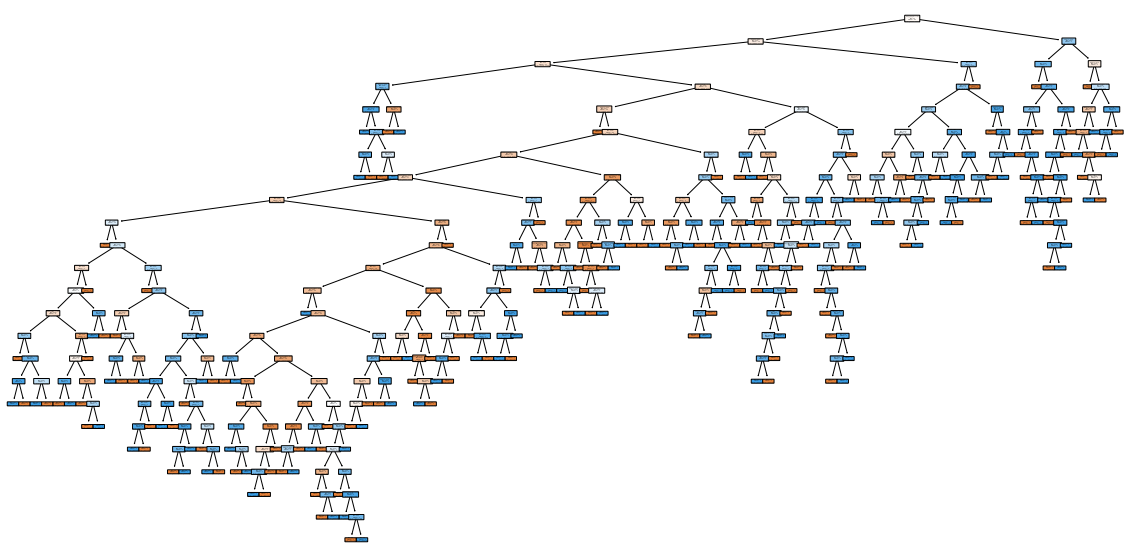

In [ ]:
rfc = RandomForestClassifier(random_state=SEED, class_weight=class_weight)
rfc.fit(X, y)
fig = plt.figure(figsize=(20, 10))
plot_tree(rfc.estimators_[0], 
          feature_names=df_model.drop(columns='category').columns,
          filled=True,
          rounded=True, );

In [ ]:
rfc = RandomForestClassifier(random_state=SEED)
df_default_rfc = valid(rfc, X, y)
df_default_rfc

,Modelo,Media,std,Pior,Melhor,Parametros
0,RandomForestClassifier,0.517644,0.016192,0.482198,0.555857,"{'bootstrap': True, 'ccp_alpha': 0.0, 'class_w..."


### Ajuste de hiperparametros

In [ ]:
params_rfc = {
    'n_estimators':range(70, 151, 10),
    'criterion':['gini', 'entropy'], 
    'max_depth':range(20, 41, 5), 
    'min_samples_split':range(15, 25, 2), 
    'min_samples_leaf':range(50, 61, 1), 
    'max_features':['log2', 'auto'],
    'class_weight':[class_weight]
    }

rfc = RandomForestClassifier(random_state=SEED)
best_params_rfc, df_rs_rfc = hp_tunning(rfc, params_rfc)

Testando hiperparametros para RandomForestClassifier
Fitting 100 folds for each of 100 candidates, totalling 10000 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:    7.5s
[Parallel(n_jobs=-1)]: Done 196 tasks      | elapsed:   35.5s
[Parallel(n_jobs=-1)]: Done 446 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done 796 tasks      | elapsed:  2.6min
[Parallel(n_jobs=-1)]: Done 1246 tasks      | elapsed:  4.2min
[Parallel(n_jobs=-1)]: Done 1796 tasks      | elapsed:  6.4min
[Parallel(n_jobs=-1)]: Done 2446 tasks      | elapsed:  8.8min
[Parallel(n_jobs=-1)]: Done 3196 tasks      | elapsed: 11.2min
[Parallel(n_jobs=-1)]: Done 4046 tasks      | elapsed: 14.0min
[Parallel(n_jobs=-1)]: Done 4996 tasks      | elapsed: 17.6min
[Parallel(n_jobs=-1)]: Done 6046 tasks      | elapsed: 21.0min
[Parallel(n_jobs=-1)]: Done 7196 tasks      | elapsed: 25.1min
[Parallel(n_jobs=-1)]: Done 8446 tasks      | elapsed: 29.4min
[Parallel(n_jobs=-1)]: Done 9796 tasks      | elapsed: 34.5min
[Parallel(n_jobs=-1)]: Done 10000 out of 10000

In [ ]:
df_rs_rfc.head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_n_estimators,param_min_samples_split,param_min_samples_leaf,param_max_features,param_max_depth,param_criterion,param_class_weight,params,mean_test_score,std_test_score,rank_test_score
17,0.500178,0.009220,0.024172,0.001966,130,21,54,auto,25,entropy,"{1: 0.7829754601226994, 0: 0.2170245398773006}","{'n_estimators': 130, 'min_samples_split': 21,...",0.595840,0.032401,1
31,0.551141,0.011137,0.025764,0.003028,140,21,51,auto,40,entropy,"{1: 0.7829754601226994, 0: 0.2170245398773006}","{'n_estimators': 140, 'min_samples_split': 21,...",0.595620,0.032196,2
16,0.432291,0.011712,0.020589,0.001538,110,19,50,log2,35,entropy,"{1: 0.7829754601226994, 0: 0.2170245398773006}","{'n_estimators': 110, 'min_samples_split': 19,...",0.595455,0.031314,3
23,0.381923,0.009886,0.019003,0.002062,100,21,57,log2,25,entropy,"{1: 0.7829754601226994, 0: 0.2170245398773006}","{'n_estimators': 100, 'min_samples_split': 21,...",0.595255,0.031285,4
43,0.586177,0.013085,0.028498,0.003445,150,21,50,auto,20,entropy,"{1: 0.7829754601226994, 0: 0.2170245398773006}","{'n_estimators': 150, 'min_samples_split': 21,...",0.595237,0.032182,5


### Melhor Random Forest

In [ ]:
best_params_rfc

{'class_weight': {0: 0.2170245398773006, 1: 0.7829754601226994},
 'criterion': 'entropy',
 'max_depth': 20,
 'max_features': 'log2',
 'min_samples_leaf': 59,
 'min_samples_split': 19,
 'n_estimators': 80}

{'class_weight': {0: 0.2170245398773006, 1: 0.7829754601226994},
 'criterion': 'entropy',
 'max_depth': 20,
 'max_features': 'log2',
 'min_samples_leaf': 59,
 'min_samples_split': 19,
 'n_estimators': 80}

In [ ]:
rfc = RandomForestClassifier(**best_params_rfc, random_state=SEED)
df_best_rfc = valid(rfc, X, y)
df_best_rfc

,Modelo,Media,std,Pior,Melhor,Parametros
0,RandomForestClassifier,0.594761,0.03065,0.524252,0.66628,"{'bootstrap': True, 'ccp_alpha': 0.0, 'class_w..."


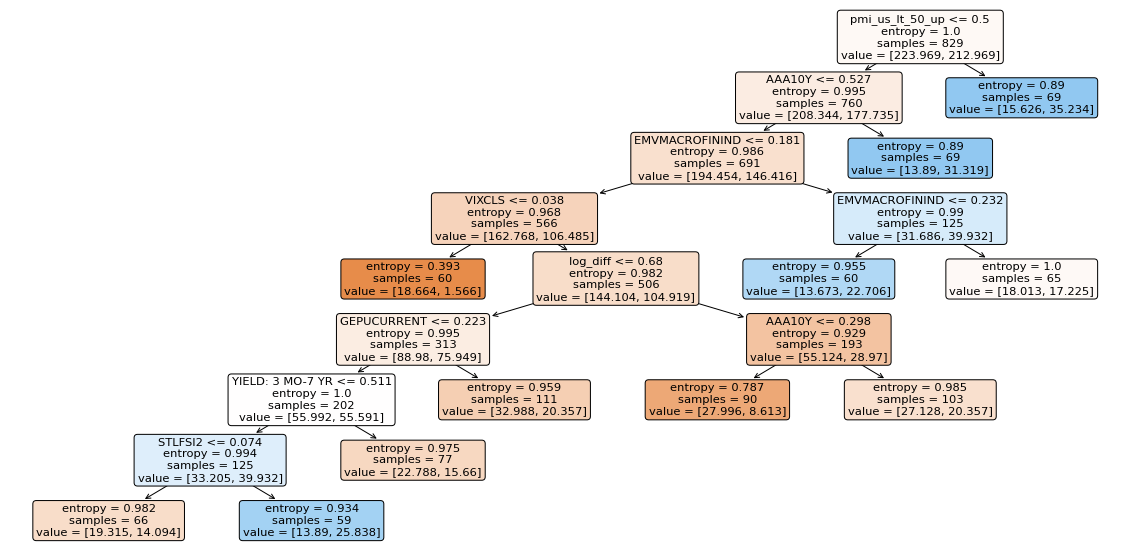

In [ ]:
rfc.fit(X, y)
fig = plt.figure(figsize=(20, 10))
plot_tree(rfc.estimators_[0], 
          feature_names=df_model.drop(columns='category').columns,
          filled=True,
          rounded=True, );

## **SVC**

In [ ]:
svc = SVC(random_state=SEED)
df_default_svc = valid(svc, X, y)
df_default_svc

,Modelo,Media,std,Pior,Melhor,Parametros
0,SVC,0.500601,0.004104,0.492647,0.515093,"{'C': 1.0, 'break_ties': False, 'cache_size': ..."


In [ ]:
svc = SVC(random_state=SEED, class_weight=class_weight)
df_default_svc = valid(svc, X, y)
df_default_svc

,Modelo,Media,std,Pior,Melhor,Parametros
0,SVC,0.591999,0.032624,0.508514,0.664216,"{'C': 1.0, 'break_ties': False, 'cache_size': ..."


### Ajuste de hiperparametros

In [ ]:
params_svc = {
    'C': range(100, 301, 10),
    'kernel':['poly', 'sigmoid', 'rbf', 'linear', ],
    'gamma':['scale', 'auto'],
    'degree': range(1, 10, 1),
    'class_weight':[class_weight]
    }

svc = SVC(random_state=SEED)
best_params_svc, df_rs_svc = hp_tunning(svc, params_svc)

Testando hiperparametros para SVC
Fitting 100 folds for each of 100 candidates, totalling 10000 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  88 tasks      | elapsed:    5.0s
[Parallel(n_jobs=-1)]: Done 388 tasks      | elapsed:   24.5s
[Parallel(n_jobs=-1)]: Done 888 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 1588 tasks      | elapsed:  2.1min
[Parallel(n_jobs=-1)]: Done 2104 tasks      | elapsed:  3.3min
[Parallel(n_jobs=-1)]: Done 3086 tasks      | elapsed:  4.8min
[Parallel(n_jobs=-1)]: Done 4002 tasks      | elapsed:  6.3min
[Parallel(n_jobs=-1)]: Done 5286 tasks      | elapsed:  7.7min
[Parallel(n_jobs=-1)]: Done 6986 tasks      | elapsed:  9.7min
[Parallel(n_jobs=-1)]: Done 8602 tasks      | elapsed: 12.4min
[Parallel(n_jobs=-1)]: Done 9688 tasks      | elapsed: 13.6min
[Parallel(n_jobs=-1)]: Done 10000 out of 10000 | elapsed: 13.9min finished


In [ ]:
df_rs_svc.head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_kernel,param_gamma,param_degree,param_class_weight,param_C,params,mean_test_score,std_test_score,rank_test_score
9,0.101829,0.004027,0.019287,0.001939,rbf,auto,7,"{1: 0.7829754601226994, 0: 0.2170245398773006}",110,"{'kernel': 'rbf', 'gamma': 'auto', 'degree': 7...",0.603698,0.032911,1
90,0.101047,0.003178,0.019765,0.002428,rbf,auto,2,"{1: 0.7829754601226994, 0: 0.2170245398773006}",100,"{'kernel': 'rbf', 'gamma': 'auto', 'degree': 2...",0.602326,0.033459,2
59,0.103774,0.004375,0.019119,0.002174,rbf,auto,4,"{1: 0.7829754601226994, 0: 0.2170245398773006}",150,"{'kernel': 'rbf', 'gamma': 'auto', 'degree': 4...",0.601916,0.031956,3
92,0.104521,0.004166,0.019548,0.003032,rbf,auto,1,"{1: 0.7829754601226994, 0: 0.2170245398773006}",160,"{'kernel': 'rbf', 'gamma': 'auto', 'degree': 1...",0.601603,0.032096,4
39,0.104494,0.003380,0.018784,0.001168,rbf,auto,5,"{1: 0.7829754601226994, 0: 0.2170245398773006}",160,"{'kernel': 'rbf', 'gamma': 'auto', 'degree': 5...",0.601603,0.032096,4


### Melhor SVC

In [ ]:
best_params_svc # {'kernel': 'rbf', 'gamma': 'auto', 'degree': 5, 'class_weight': {1: 0.7832436587240584, 0: 0.2167563412759416}, 'C': 160}

{'C': 110,
 'class_weight': {0: 0.2170245398773006, 1: 0.7829754601226994},
 'degree': 7,
 'gamma': 'auto',
 'kernel': 'rbf'}

In [ ]:
df_best_svc = valid(SVC(**best_params_svc), X,y)
df_best_svc

,Modelo,Media,std,Pior,Melhor,Parametros
0,SVC,0.599986,0.031504,0.526703,0.685243,"{'C': 110, 'break_ties': False, 'cache_size': ..."


## **SGDClassifier**

In [ ]:
sgd = SGDClassifier(random_state=SEED)
df_default_sgd = valid(sgd, X, y)
df_default_sgd

,Modelo,Media,std,Pior,Melhor,Parametros
0,SGDClassifier,0.519972,0.023746,0.490196,0.590428,"{'alpha': 0.0001, 'average': False, 'class_wei..."


In [ ]:
sgd = SGDClassifier(random_state=SEED, class_weight=class_weight)
df_default_sgd = valid(sgd, X, y)
df_default_sgd

,Modelo,Media,std,Pior,Melhor,Parametros
0,SGDClassifier,0.549736,0.031645,0.478715,0.65338,"{'alpha': 0.0001, 'average': False, 'class_wei..."


### Ajuste de Hiperparametros

In [ ]:
params_sgd = {
    'loss':['hinge', 'log', 'squared_hinge', 'modified_huber',  'perceptron'],
    'penalty':['l2', 'l1', 'elasticnet'],
    'alpha':[1e-3, 1e-2, 1e-1],
    'max_iter':range(5000, 19001, 2000), 
    'n_iter_no_change': [15],
    'class_weight':[class_weight]
    }

sgd = SGDClassifier(random_state=SEED)
best_params_sgd, df_rs_sgd = hp_tunning(sgd, params_sgd)

Testando hiperparametros para SGDClassifier
Fitting 100 folds for each of 100 candidates, totalling 10000 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  88 tasks      | elapsed:    5.6s
[Parallel(n_jobs=-1)]: Done 1076 tasks      | elapsed:   45.1s
[Parallel(n_jobs=-1)]: Done 2298 tasks      | elapsed:  5.5min
[Parallel(n_jobs=-1)]: Done 4422 tasks      | elapsed:  8.0min
[Parallel(n_jobs=-1)]: Done 9451 tasks      | elapsed: 11.4min
[Parallel(n_jobs=-1)]: Done 10000 out of 10000 | elapsed: 11.8min finished


In [ ]:
df_rs_sgd.head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_penalty,param_n_iter_no_change,param_max_iter,param_loss,param_class_weight,param_alpha,params,mean_test_score,std_test_score,rank_test_score
4,0.011947,0.003632,0.001654,0.000237,l2,15,9000,modified_huber,"{1: 0.7829754601226994, 0: 0.2170245398773006}",0.01,"{'penalty': 'l2', 'n_iter_no_change': 15, 'max...",0.591867,0.034594,1
3,0.024358,0.006226,0.001632,0.000057,elasticnet,15,7000,log,"{1: 0.7829754601226994, 0: 0.2170245398773006}",0.001,"{'penalty': 'elasticnet', 'n_iter_no_change': ...",0.590855,0.032487,2
2,0.018509,0.031355,0.001665,0.000339,elasticnet,15,17000,squared_hinge,"{1: 0.7829754601226994, 0: 0.2170245398773006}",0.1,"{'penalty': 'elasticnet', 'n_iter_no_change': ...",0.564996,0.044738,3
0,0.121888,0.034818,0.001791,0.000652,l2,15,7000,squared_hinge,"{1: 0.7829754601226994, 0: 0.2170245398773006}",0.001,"{'penalty': 'l2', 'n_iter_no_change': 15, 'max...",0.552879,0.038193,4
1,0.010955,0.003060,0.001746,0.000636,l1,15,7000,modified_huber,"{1: 0.7829754601226994, 0: 0.2170245398773006}",0.1,"{'penalty': 'l1', 'n_iter_no_change': 15, 'max...",0.500000,0.000000,5


### Melhor SGDClassifier

In [ ]:
best_params_sgd # {'penalty': 'elasticnet', 'n_iter_no_change': 15, 'max_iter': 17000, 'loss': 'modified_huber', 'class_weight': {1: 0.7832436587240584, 0: 0.2167563412759416}, 'alpha': 0.01}

{'alpha': 0.001,
 'class_weight': {0: 0.2170245398773006, 1: 0.7829754601226994},
 'loss': 'log',
 'max_iter': 5000,
 'n_iter_no_change': 15,
 'penalty': 'l1'}

In [ ]:
best_sgd = SGDClassifier(**best_params_sgd)
df_best_sgd = valid(best_sgd, X, y)
df_best_sgd

,Modelo,Media,std,Pior,Melhor,Parametros
0,SGDClassifier,0.590739,0.029784,0.503741,0.655702,"{'alpha': 0.001, 'average': False, 'class_weig..."



# Comparação dos modelos

---

In [ ]:
try: 
  df_rs_rfc['modelo'] = 'RandomForestClassifier'
  df_rs_svc['modelo'] = 'SVC'
  df_rs_sgd['modelo'] = 'SGDClassifier'
  col = [c for c in df_rs_rfc.columns  if not any([c.startswith('param_'), c.startswith('rank')])]

  df_results = pd.concat([df_rs_rfc[col][:5], 
                          df_rs_svc[col][:5], 
                          df_rs_sgd[col][:5],
                          ]).sort_values('mean_test_score', ascending=False).reset_index()
  df_results.rename(columns={'index': 'n_execucao'}, inplace=True)
  df_results.to_csv('/content/drive/MyDrive/TCC Puc Minas/df_results.csv', index=False)
except:
  df_results = pd.read_csv('/content/drive/MyDrive/TCC Puc Minas/df_results.csv')

In [ ]:
df_results[['modelo', 'mean_test_score', 'std_test_score','mean_fit_time' ]].head(15)

,modelo,mean_test_score,std_test_score,mean_fit_time
0,SVC,0.603698,0.032911,0.101829
1,SVC,0.602326,0.033459,0.101047
2,SVC,0.601916,0.031956,0.103774
3,SVC,0.601603,0.032096,0.104521
4,SVC,0.601603,0.032096,0.104494
5,RandomForestClassifier,0.595840,0.032401,0.500178
6,RandomForestClassifier,0.595620,0.032196,0.551141
7,RandomForestClassifier,0.595455,0.031314,0.432291
8,RandomForestClassifier,0.595255,0.031285,0.381923
9,RandomForestClassifier,0.595237,0.032182,0.586177


In [ ]:
fig = px.scatter(df_results, y='mean_test_score', x='mean_fit_time', color='modelo', symbol='modelo', width=800, height=600)
fig.update_traces(marker_size=10)
fig.update_layout(title="Acuracia Balanceada x Tempo de treino", yaxis_range=[0,1], xaxis_range=[0,1])
fig.update_yaxes(tickformat = '.2%')  
fig.show()

## Outras metricas

In [ ]:
scoring = ['accuracy', 'f1', 'neg_log_loss', 'precision', 'recall']

def valid_scores(linha):
  clf = eval(linha[1]+'()')
  if linha[1] == 'SVC':
    clf.set_params(**literal_eval(linha[2]), probability=True)
  else:
    clf.set_params(**literal_eval(linha[2]))
  scores = cross_validate(clf, X, y, scoring=scoring, cv=ss, n_jobs=-1)
  df = pd.DataFrame([{k: v.mean() for k,v in scores.items()}])
  df['modelo'] = linha[1]
  return df[['modelo', 'test_accuracy', 'test_f1','test_neg_log_loss', 
             'test_precision', 'test_recall',]]

In [ ]:
df_new_scores = pd.concat([valid_scores(linha) for linha in df_results[['modelo', 'params']].itertuples()])

In [ ]:
df_new_scores

,modelo,test_accuracy,test_f1,test_neg_log_loss,test_precision,test_recall
0,SVC,0.648467,0.393796,-0.506276,0.316286,0.524211
0,SVC,0.648199,0.392037,-0.506045,0.315244,0.520877
0,SVC,0.645977,0.391910,-0.506249,0.313999,0.523684
0,SVC,0.645785,0.391568,-0.506167,0.313747,0.523158
0,SVC,0.645785,0.391568,-0.506339,0.313747,0.523158
0,RandomForestClassifier,0.650421,0.381981,-0.643244,0.311661,0.496140
0,RandomForestClassifier,0.655057,0.383091,-0.641054,0.314918,0.491930
0,RandomForestClassifier,0.653678,0.382250,-0.641081,0.313922,0.491754
0,RandomForestClassifier,0.650268,0.382686,-0.643936,0.311994,0.497719
0,RandomForestClassifier,0.655632,0.382685,-0.641318,0.314975,0.490000


## Teste pratico

In [ ]:
qtd = int(y.size * 0.15)
X_train = X[:-qtd]
y_train = y[:-qtd]
X_teste = X[-qtd:]
y_teste = y[-qtd:]

train_class_weight = {1: y_train[y_train == 0].size / y_train.size,
                      0: y_train[y_train == 1].size / y_train.size} 
train_class_weight

{0: 0.2236248872858431, 1: 0.7763751127141569}

In [ ]:
df_results['params'].values[0]

"{'kernel': 'rbf', 'gamma': 'auto', 'degree': 7, 'class_weight': {1: 0.7829754601226994, 0: 0.2170245398773006}, 'C': 110}"

In [ ]:
params = {'C': 110,
          'class_weight':train_class_weight,
          'degree': 7,
          'gamma': 'auto',
          'kernel': 'rbf'}

svc = SVC(**params, probability=True).fit(X_train, y_train)
predict = svc.predict(X_teste)
proba = svc.predict_proba(X_teste)[:,1]

In [ ]:
df_case = df_join.loc[~log_diff_null.values][['Date', 'log_diff']]
df_pred = pd.DataFrame({'real': y_teste, 'predict': predict, 'proba_queda': proba}, index=df_case.index[-qtd:])
df_case = df_case.merge(df_pred, left_index=True, right_index=True, how='outer')
df_case.dropna(inplace=True)

In [ ]:
df_case

,Date,log_diff,real,predict,proba_queda
2018-04,2018-02-02,-0.034863,1.0,0.0,0.157487
2018-05,2018-02-09,-0.059211,1.0,0.0,0.208820
2018-06,2018-02-16,0.042396,0.0,0.0,0.200992
2018-07,2018-02-23,0.002902,0.0,0.0,0.210861
2018-08,2018-03-02,-0.024688,1.0,0.0,0.213037
...,...,...,...,...,...
2021-35,2021-09-03,0.012433,0.0,0.0,0.109627
2021-36,2021-09-10,-0.012376,0.0,0.0,0.083101
2021-37,2021-09-17,-0.009942,0.0,0.0,0.086452
2021-38,2021-09-24,0.000645,0.0,0.0,0.089633


In [ ]:
df_case[df_case['real']==1].sum()

log_diff       -1.290861
real           35.000000
predict         2.000000
proba_queda     5.405820
dtype: float64

In [ ]:
df_case[df_case['predict']==1]

,Date,log_diff,real,predict,proba_queda
2018-48,2018-12-07,-0.035199,1.0,1.0,0.238687
2020-10,2020-03-13,-0.132277,1.0,1.0,0.244937


In [ ]:
df_case['pred_class'] = df_case['predict'].astype('str')
fig = px.scatter(
    df_case[(df_case['predict']==1)|(df_case['real']==1)],
    y='log_diff',
    x='Date',
    color='pred_class',
)
fig.update_traces(marker_size=8)
fig.update_layout(title="Log Diff e valores previstos")
fig.update_yaxes(tickformat = '.2%')  
fig.show()